In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/config.json
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/tokenizer.json
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/tf_model.h5
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/pytorch_model.bin
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/vocab.txt
/kaggle/input/bert-base-multilingual-cased/bert-base-multilingual-cased/flax_model.msgpack
/kaggle/input/bertbasecased/config.json
/kaggle/input/bertbasecased/tokenizer.json
/kaggle/input/bertbasecased/tokenizer_config.json
/kaggle/input/bertbasecased/pytorch_model.bin
/kaggle/input/bertbasecased/vocab.txt


In [2]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [3]:
kf = KFold(n_splits=5)
kfolds_data = kf.split(train_data_raw)

partition = 1
for train_index, test_index in kfolds_data:
    train = pd.DataFrame(train_data_raw.values[train_index])
    train.columns = train_data_raw.columns

#     test = pd.DataFrame(train_data_raw.values[test_index])
#     test.columns = train_data_raw.columns
    
    train.to_csv(f'/kaggle/working/train_partition_{partition}.csv')
#     test.to_csv(f'/kaggle/working/test_partition_{partition}.csv')
    
    partition +=1
    
train = pd.read_csv('/kaggle/working/train_partition_1.csv').iloc[:,1:]

In [4]:
#tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bertbasecased/")

#essay =  train['full_text'][0]
longest_essay_length = train['full_text'].apply(len).max()

def tokenize(essays):
    return [
            tokenizer.encode(
            x,
            padding='max_length',
            max_length=longest_essay_length,
            truncation=True,
            add_special_tokens= False, #if treue [CLS] and [SEP] get added to each tokenizing.
            ) for x in essays]

encoded_essays_train = tokenize(train['full_text'])
#tokenizer.decode(essay_word_indices)

#sc_x_essays = StandardScaler()
#sc_x_essays_train = sc_x_essays.fit_transform(encoded_essays_train)
encoded_essays_train = tf.convert_to_tensor(encoded_essays_train)

essay_length_train = train['full_text'].str.len()
essay_length_train = tf.convert_to_tensor(essay_length_train)

encoded_essays_test = tokenize(test['full_text'])
encoded_essays_test = tf.convert_to_tensor(encoded_essays_test)

essay_length_test = test['full_text'].str.len()
essay_length_test = tf.convert_to_tensor(essay_length_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']])

encoded_cohesion_score = y_train[:,0]
encoded_syntax_score = y_train[:,1]
encoded_vocabulary_score = y_train[:,2]
encoded_phraseology_score = y_train[:,3]
encoded_grammar_score = y_train[:,4]
encoded_conventions_score = y_train[:,5]


2022-11-13 18:30:16.891516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 18:30:16.991630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 18:30:16.992361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 18:30:16.994791: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
pd.DataFrame(y_train).describe().round()

,0,1,2,3,4,5
count,3128.0,3128.0,3128.0,3128.0,3128.0,3128.0
mean,-0.0,0.0,0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.0,-3.0,-4.0,-3.0,-3.0,-3.0
25%,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,1.0,1.0,0.0,1.0,1.0,1.0
max,3.0,3.0,3.0,3.0,3.0,3.0


In [6]:
vocab_size_train =tokenizer.vocab_size + 2
embedding_dim = 64
tokenizer.vocab_size

keras.backend.clear_session()
#model
essay_input = keras.Input(shape=(longest_essay_length,), name='essay_input' )

length_input = keras.Input(shape=(1,), name='length_input') 

concated_layers = tf.keras.layers.Concatenate(axis=1)([essay_input, length_input, ])

embedding = layers.Embedding(vocab_size_train, embedding_dim, name="embedding")(concated_layers)

conv_x =  layers.Conv1D( filters=64, kernel_size=3, padding='same', activation='relu')(embedding)
conv_x =  layers.Dropout(rate=0.8)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

conv_x =  layers.Conv1D( filters=32, kernel_size=4, padding='same', activation='relu')(conv_x)
conv_x =  layers.Dropout(rate=0.8)(conv_x)
max_pooling_x = layers.MaxPooling1D()(conv_x)

conv_x =  layers.Conv1D( filters=16, kernel_size=5, padding='same', activation='relu')(conv_x)
conv_x =  layers.Dropout(rate=0.8)(conv_x)
#max_pooling_x = layers.MaxPooling1D()(conv_x)

#max_pooling_x = layers.MaxPooling1D()(conv_x)

average_pooling_x = layers.GlobalAveragePooling1D()(max_pooling_x)

#flattener = layers.Flatten()(average_pooling_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)

dense_x = layers.Dense(16, activation="relu")(average_pooling_x)
dense_x =  layers.Dropout(rate=0.2)(dense_x)


cohesion_prediction = layers.Dense(1, use_bias=True, activation=None, name='cohesion_prediction')(dense_x)
syntax_prediction = layers.Dense(1, use_bias=True, activation=None, name='syntax_prediction')(dense_x)
vocabulary_prediction = layers.Dense(1, use_bias=True, activation=None, name='vocabulary_prediction')(dense_x)
phraseology_prediction = layers.Dense(1, use_bias=True, activation=None, name='phraseology_prediction')(dense_x)
grammar_prediction = layers.Dense(1, use_bias=True, activation=None, name='grammar_prediction')(dense_x)
conventions_prediction = layers.Dense(1, use_bias=True, activation=None, name='conventions_prediction')(dense_x)

grader = keras.Model(
    inputs=[
        essay_input,
        length_input
    ],
    outputs=[
        cohesion_prediction, 
        syntax_prediction,
        vocabulary_prediction,
        phraseology_prediction,
        grammar_prediction,
        conventions_prediction
    ],
    )

grader.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_input (InputLayer)        [(None, 6044)]       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 6045)         0           essay_input[0][0]                
                                                                 length_input[0][0]               
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6045, 64)     1855872     concatenate[0][0]            

In [7]:
grader.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )])

hist = grader.fit(
    x={
        'essay_input': encoded_essays_train,
        'length_input': essay_length_train
    },
    y={
     'cohesion_prediction': encoded_cohesion_score, 
     'syntax_prediction': encoded_syntax_score,
     'vocabulary_prediction': encoded_vocabulary_score,
     'phraseology_prediction': encoded_phraseology_score,
     'grammar_prediction': encoded_grammar_score,
     'conventions_prediction': encoded_conventions_score
    },
    
    batch_size=32,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1,
    epochs=10, 
    )

Epoch 1/10


2022-11-13 18:30:20.235138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-13 18:30:22.708550: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


88/88 [==============================] - 12s 37ms/step - loss: 4.7694 - cohesion_prediction_loss: 0.8001 - syntax_prediction_loss: 0.7694 - vocabulary_prediction_loss: 0.8017 - phraseology_prediction_loss: 0.8191 - grammar_prediction_loss: 0.7998 - conventions_prediction_loss: 0.7793 - cohesion_prediction_root_mean_squared_error: 1.0124 - syntax_prediction_root_mean_squared_error: 1.0055 - vocabulary_prediction_root_mean_squared_error: 1.0153 - phraseology_prediction_root_mean_squared_error: 1.0035 - grammar_prediction_root_mean_squared_error: 1.0061 - conventions_prediction_root_mean_squared_error: 1.0079 - val_loss: 4.6461 - val_cohesion_prediction_loss: 0.7816 - val_syntax_prediction_loss: 0.7335 - val_vocabulary_prediction_loss: 0.7765 - val_phraseology_prediction_loss: 0.8005 - val_grammar_prediction_loss: 0.7840 - val_conventions_prediction_loss: 0.7700 - val_cohesion_prediction_root_mean_squared_error: 0.9746 - val_syntax_prediction_root_mean_squared_error: 0.9607 - val_vocabula

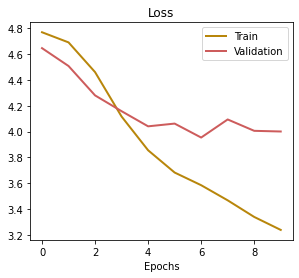

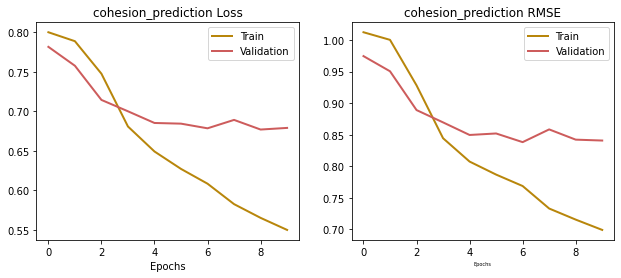

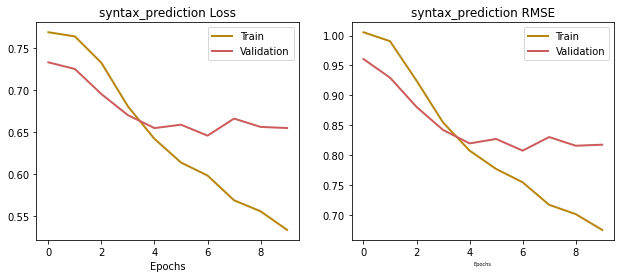

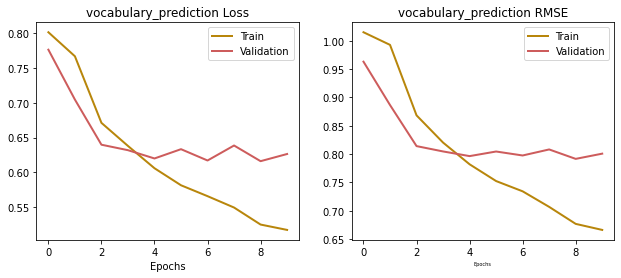

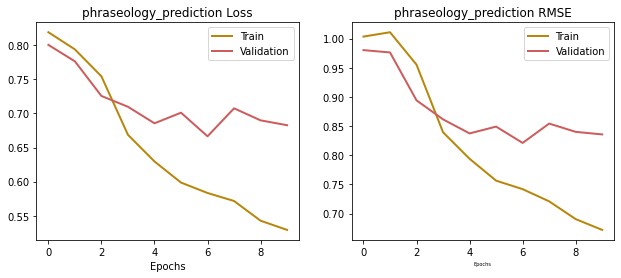

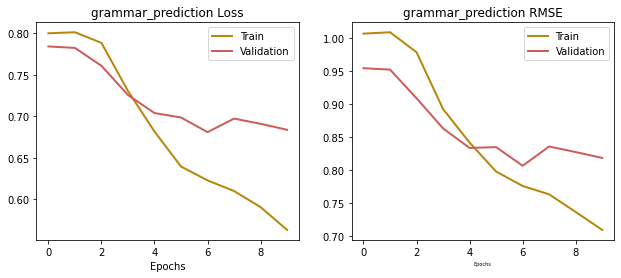

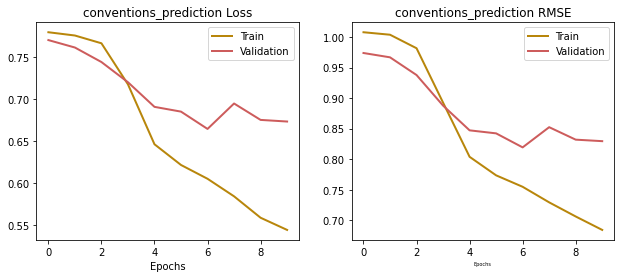

In [8]:
# grab history
history = hist.history

outputs = [ 'cohesion_prediction', 'syntax_prediction', 'vocabulary_prediction', 'phraseology_prediction', 'grammar_prediction', 'conventions_prediction' ]

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');
    

for output in outputs:
    # plot loss for train and validation
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history[f'{output}_loss'], lw=2, color='darkgoldenrod')
    plt.plot(history[f'val_{output}_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title(f'{output} Loss');

    # plot accuracy for train and validation
    ax = fig.add_subplot(1, 3, 2)
    plt.plot(history[f'{output}_root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history[f'val_{output}_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.7,0.8)
    ax.set_xlabel('Epochs', size=5)
    ax.set_title(f'{output} RMSE');


In [9]:
predictions = grader.predict(
                            {
                'essay_input': encoded_essays_train,
                'length_input': essay_length_train
            })
predictions = pd.DataFrame(np.array(predictions).reshape(6,-1)).T
predictions = sc_y.inverse_transform(predictions.values)
predictions = pd.DataFrame(predictions)
predictions

,0,1,2,3,4,5
0,3.241279,3.125349,3.293307,3.212810,3.107881,3.197003
1,3.317878,3.239471,3.397671,3.299034,3.159870,3.276702
2,3.620213,3.543096,3.674330,3.602044,3.528321,3.566765
3,3.555876,3.449860,3.593807,3.533304,3.466505,3.501306
4,2.924085,2.832217,3.039717,2.897179,2.806909,2.873914
...,...,...,...,...,...,...
3123,2.850021,2.768718,2.987351,2.829152,2.742927,2.796955
3124,3.285586,3.203350,3.365017,3.267036,3.122619,3.245413
3125,2.982699,2.884980,3.084501,2.955549,2.850874,2.935776
3126,3.392601,3.299811,3.454549,3.368419,3.258530,3.346508


In [10]:
predictions.describe()

,0,1,2,3,4,5
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,3.148151,3.055194,3.240632,3.130765,3.012033,3.101220
std,0.265605,0.259836,0.226037,0.256212,0.273448,0.266507
min,1.833561,1.897766,2.321045,2.034925,1.721045,1.756146
25%,2.936786,2.841476,3.054165,2.922988,2.797575,2.888792
50%,3.161957,3.061704,3.236414,3.139743,3.004244,3.120142
75%,3.331633,3.226443,3.388432,3.300388,3.191246,3.286255
max,4.250905,4.237731,4.300357,4.270548,4.268647,4.179817


In [11]:
test_predictions = grader.predict(
                    {
                'essay_input': encoded_essays_test,
                'length_input': essay_length_test
            }
        )
test_predictions = pd.DataFrame(np.array(test_predictions).reshape(6,-1)).T
test_predictions = sc_y.inverse_transform(test_predictions.values)
test_predictions = pd.DataFrame(test_predictions)
test_predictions
# test_predictions

,0,1,2,3,4,5
0,3.065578,2.961820,3.169261,3.082067,2.836388,3.032144
1,2.940203,2.845821,3.056287,2.920976,2.800579,2.892757
2,3.276727,3.168979,3.337244,3.246130,3.124673,3.233435


In [12]:
test['cohesion'] = test_predictions[0]
test['syntax'] = test_predictions[1]
test['vocabulary'] = test_predictions[2]
test['phraseology'] = test_predictions[3]
test['grammar'] = test_predictions[4]
test['conventions'] = test_predictions[5]
test

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.065578,2.961820,3.169261,3.082067,2.836388,3.032144
1,000BAD50D026,Do you think students would benefit from being...,2.940203,2.845821,3.056287,2.920976,2.800579,2.892757
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.276727,3.168979,3.337244,3.246130,3.124673,3.233435


In [13]:
test

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.065578,2.961820,3.169261,3.082067,2.836388,3.032144
1,000BAD50D026,Do you think students would benefit from being...,2.940203,2.845821,3.056287,2.920976,2.800579,2.892757
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.276727,3.168979,3.337244,3.246130,3.124673,3.233435


In [14]:
res = test.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)